In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, models, plot
from pathlib import Path

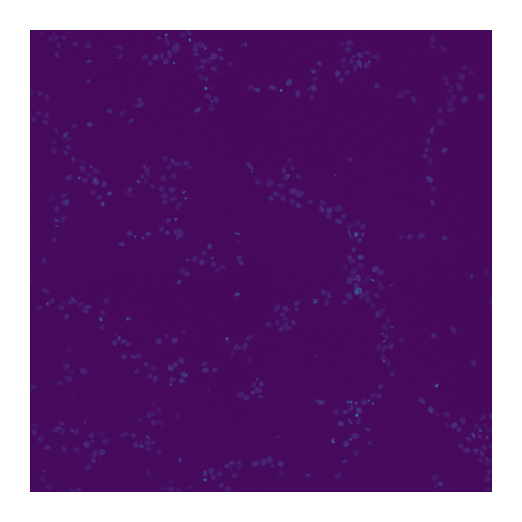

m = 1864, n = 1864, nzslices = 4



In [2]:
# get a list of files to segment
dataDir = Path(os.getcwd())

nucChannel = 0 #nuclear channel
files = []
for filename in Path(dataDir).rglob("*_p*_w%.4d_t*.tif" % nucChannel):
    filepath = os.path.split(filename)[0]
    #TODO: exclude files containing "FinalSegmentation" in the name
    if (filepath == str(dataDir)) & ('FinalSegmentation' not in str(filename)) & ('_cp_masks' not in str(filename)):
        files.append(filename)
    #print(filename)

# view 1 image
img = io.imread(files[0])
nzslices = img.shape[0] #number of z slices
m = img.shape[1]
n = img.shape[2]
plt.figure(figsize=(2,2))
#look at z slice 4
plt.imshow(img[2,:,:])
plt.axis('off')
plt.show()
print('m = %d, n = %d, nzslices = %d\n' % (m,n,nzslices))

In [3]:
files

[WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0000.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0001.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0002.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0003.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0004.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0005.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0006.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0007.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0008.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0009.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0010.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitched_p0000_w0000_t0011.tif'),
 WindowsPath('I:/protocolsTestData_copy/live/stitche

In [4]:
def rescale_intensity(im,p1,p99):
    #function to rescale image intensity values based on maximum and minimum percentiles
    #images are converted to floats with intensity values in the range (0,1)
    im[im<p1] = p1
    im[im>p99] = p99
    imnew = (im - p1)/(p99 - p1)
    return imnew


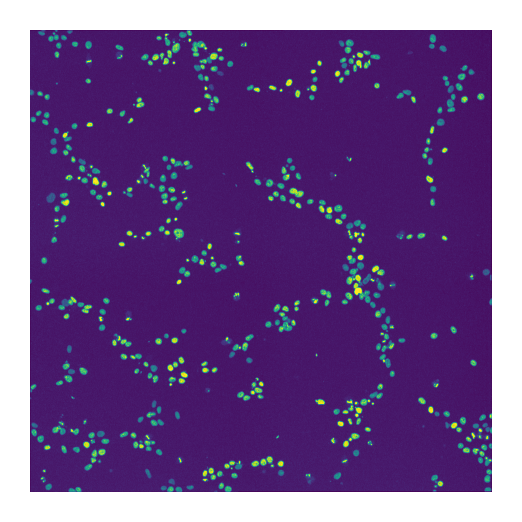

In [5]:
#display image with rescaled + saturated intensity
#from skimage import exposure
im = img[2,:,:]
p1, p99 = np.percentile(im, (1, 99))
J = rescale_intensity(im, p1, p99)

plt.figure(figsize=(2,2))
plt.imshow(J)
plt.axis('off')
plt.show()

In [6]:
#run the model once
#if you set diameter=None in the call to model.eval, it will run the model once to estimate the size of nuclei and run again
#to do actual segmentation but this is slow and works less well on the micropattern than on sparser disordered cells
#I generally estimate in Fiji instead; for 40x, nuclear diameter generally ranges from ~25-70 pixels (~8-22 um)
model = models.Cellpose(gpu=True, model_type='nuclei')
chan = [0,0] #use chan = [0,0] for nuclear segmentation only
diam = 22

im = img[2,:,:]
p1, p99 = np.percentile(im, (1, 99))
J = rescale_intensity(im, p1,p99)
masks, flows, styles, diams = model.eval(J, diameter=diam, channels=chan)

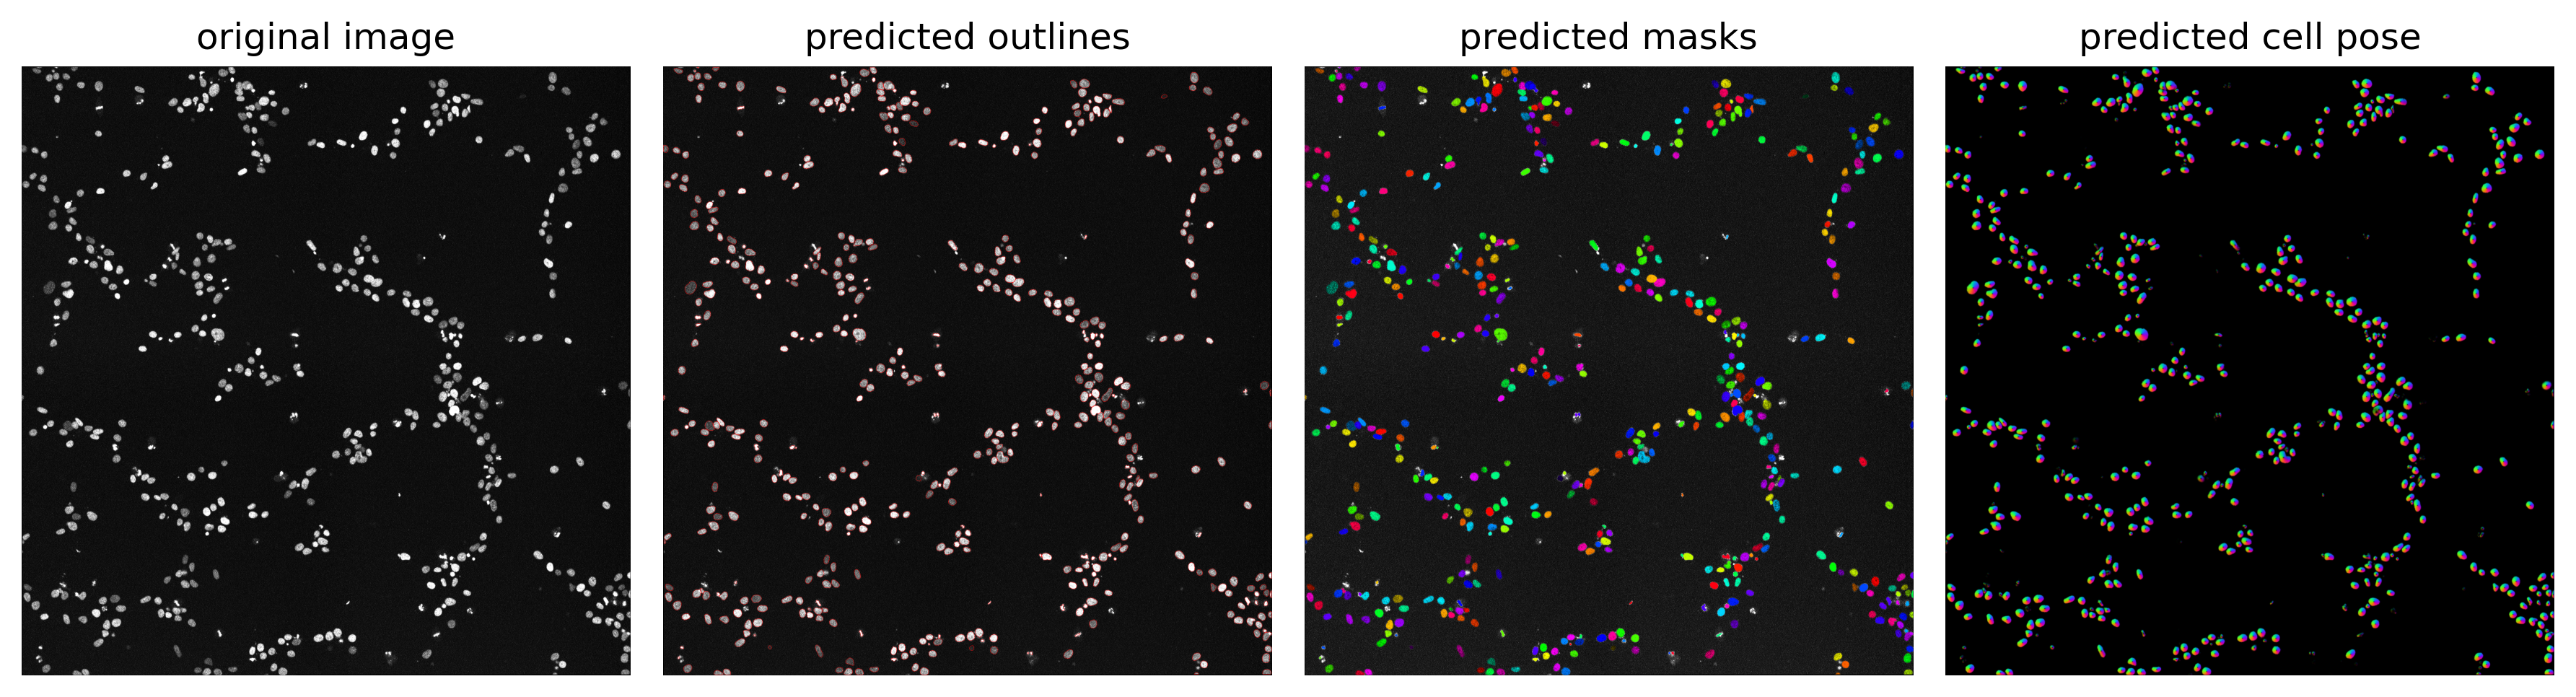

In [7]:
# DISPLAY RESULTS
#The built-in way of doing this is extremely slow, I've been saving results and visualizing in matlab instead
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, J, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

In [8]:
# RUN CELLPOSE

# process files and z slices in a loop
for filename in files:
    base = os.path.splitext(filename)[0]
    print(base)
    img = io.imread(filename)
    nzslices = img.shape[0]
    for zi in range(0,nzslices):
        im = img[zi,:,:]
        p1, p99 = np.percentile(im, (1, 99))
        J = rescale_intensity(im,p1,p99)
        masks, flows, styles, diams = model.eval(J, diameter=diam, channels=chan)
        # save results as png
        masks = masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32)
        io.imsave(base + '_z%.4d' % zi + '_cp_masks.png', masks)
    

I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0000
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0001
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0002
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0003
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0004
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0005
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0006
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0007
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0008
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0009
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0010
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0011
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0012
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0013
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0014
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0015
I:\protocolsTestData_copy\live\stitched_p0000_w0000_t0016
I:\protocolsTe